In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json

from config import Cfg as cfg

import mysql.connector

%matplotlib inline

# Results data

In [2]:
cnx = mysql.connector.connect(user=cfg.mysql_user, database=cfg.mysql_db, password=cfg.mysql_pw, ssl_disabled=True)

query = "SELECT * FROM results;"

# execute the query and assign it to a pandas dataframe
df_results = pd.read_sql(query, con=cnx)

cnx.close()

print("Number of single results:", len(df_results))
print("Number of individuals:", len(df_results.athlete.unique()))

Number of single results: 2000403
Number of individuals: 643055


# Races data

In [3]:
df_races = pd.read_csv('./../data/clean/races_features.csv', index_col='race')
len(df_races)

159

### Some processing on the datasets

In [7]:
# -----------
# -- RESULTS --
# -----------

# worldchampionship70.3 and worldchampionship70.3m are the same race
df_results.loc[df_results.race == "worldchampionship70.3m", 'race'] = 'worldchampionship70.3'


# keep only results of non discontinued races
df_results = df_results[df_results['race'].isin(df_races.index)]

# remove world championship races since we cannot really recommend it
df_results = df_results[~df_results['race'].str.contains('worldchampionship')]

# extract gender from division
df_results['gender'] = df_results['division'].apply(lambda x: x[0])

# convert date to datetime
df_results['date'] = pd.to_datetime(df_results['date'])

# str to int
df_results['year'] = df_results['year'].apply(int)

# keep only results from after 2015
df_results = df_results.loc[df_results['year'] >= 2015]

# # discard pro athletes
# df_results = df_results.loc[df_results.division.str.contains("PRO") == False]

# Add gender
df_results['gender'] = None
df_results.loc[df_results['division'].str.contains("M"), 'gender'] = "M"
df_results.loc[df_results['division'].str.contains("F"), 'gender'] = "F"


print("Number of remaining single results:", len(df_results))
print("Number of remaining individuals:", len(df_results.athlete.unique()))
print("Number of races in results df:", len(df_results.race.unique()))

Number of remaining single results: 945102
Number of remaining individuals: 399472
Number of races in results df: 156


# Filter results dataset to keep only prolific racers
#### To prevent cold-start problem keep only people with at least 3 different races.

In [8]:
min_unique_race_count = 4

# total number of races per athlete
athletes_count_races = (df_results.groupby('athlete')['division']
     .size()
     .reset_index()
     .rename(columns={'division': 'n_races'})
)

# total number of different races per athlete
athletes_count_diff_races = (df_results
     .groupby(['athlete', 'race'])
     .size()
     .reset_index()
     .groupby('athlete')
     .size()
     .reset_index()
     .rename(columns={0: 'n_different_races'})
)

# merge the two so we can filter from that
athlete_habits = athletes_count_diff_races.merge(athletes_count_races, left_on="athlete", right_on="athlete", how="left")

# What we are filtering with
max_count_races = 100 # probably similar names

valid_athletes = athlete_habits.loc[(athlete_habits['n_different_races']>=min_unique_race_count) & (athlete_habits['n_races']<=max_count_races)]

# use this df to filter original results data
df_results_filtered = df_results.loc[df_results['athlete'].isin(valid_athletes['athlete'])]
df_results_filtered = df_results_filtered.merge(valid_athletes, left_on="athlete", right_on="athlete", how="left")

# Anonimize entrants
user_hash = {}

for i,user in enumerate(df_results_filtered.athlete.unique()):
    user_hash[user] = f'u{i}'
df_results_filtered.loc[:, 'athlete'] = df_results_filtered.athlete.map(lambda x: user_hash[x])

print("Number of valid individuals:", len(valid_athletes))
print("Number of remaining single results:", len(df_results_filtered))
print("Number of races present in filtered results:", len(df_results_filtered.race.unique()))

Number of valid individuals: 45799
Number of remaining single results: 329329
Number of races present in filtered results: 156


### Update races df to only keep races present in filtered results df

In [9]:
df_races_for_model = df_races.loc[df_results_filtered.race.unique()]
print("Number of remaining races:", len(df_races_for_model))

Number of remaining races: 156


# Create dataframe with race count per athlete

In [10]:
results_races_count = (
    df_results_filtered
        .groupby(['athlete', 'race'])
        .size()
        .reset_index()
        .rename(columns={0: 'count'})
)

# Add demographics info for users (if we want to filter later)
gender = (df_results_filtered
     .groupby(['athlete', 'gender'])
     .size()
     .reset_index()
     .rename(columns={0: 'n'})
     .pivot(index='athlete', columns='gender', values='n')
     .idxmax(axis=1)
     .rename('gender')
)

country = (df_results_filtered
     .groupby(['athlete', 'country'])
     .size()
     .reset_index()
     .rename(columns={0: 'n'})
     .pivot(index='athlete', columns='country', values='n')
     .idxmax(axis=1)
     .rename('country')
)

results_races_count = results_races_count.merge(gender, left_on = 'athlete', right_on = 'athlete', how = 'left')
results_races_count = results_races_count.merge(country, left_on = 'athlete', right_on = 'athlete', how = 'left')

results_races_count.head()

,athlete,race,count,gender,country
0,u0,cozumel,1,M,USA
1,u0,liuzhou70.3,1,M,USA
2,u0,mardelplata,1,M,USA
3,u0,newzealand,1,M,USA
4,u0,xiamen70.3,2,M,USA


# Binarize (relevant/not relevant)

In [16]:
results_races_count_binarized = results_races_count.apply(lambda x: x if x.name != 'count' else (x>0).astype(int))

# Split train/test

In [196]:
import random

def make_train(ratings, perc_test = 0.2):
    '''
    This function will take in the original user-item matrix and "mask" a percentage of the original ratings where a
    user-item interaction has taken place for use as a test set. The test set will contain all of the original ratings, 
    while the training set replaces the specified percentage of them with a zero in the original ratings matrix. 
    
    parameters: 
    
    ratings - the original ratings matrix from which you want to generate a train/test set. Test is just a complete
    copy of the original set. This is in the form of a sparse csr_matrix. 
    
    perc_test - The percentage of user-item interactions where an interaction took place that you want to mask in the 
    training set for later comparison to the test set, which contains all of the original ratings. 
    
    returns:
    
    training_set - The altered version of the original data with a certain percentage of the user-item pairs 
    that originally had interaction set back to zero.
    
    test_set - A copy of the original ratings matrix, unaltered, so it can be used to see how the rank order 
    compares with the actual interactions.
    
    user_inds - From the randomly selected user-item indices, which user rows were altered in the training data.
    This will be necessary later when evaluating the performance via AUC.
    '''
    test_set = ratings.copy() # Make a copy of the original set to be the test set. 
    test_set[test_set != 0] = 1 # Store the test set as a binary preference matrix
    
    training_set = ratings.copy() # Make a copy of the original data we can alter as our training set. 
    
    nonzero_inds = training_set.nonzero() # Find the indices in the ratings data where an interaction exists
    nonzero_pairs = list(zip(nonzero_inds[0], nonzero_inds[1])) # Zip these pairs together of item,user index into list

    
    random.seed(0) # Set the random seed to zero for reproducibility
    
    num_samples = int(np.ceil(perc_test*len(nonzero_pairs))) # Round the number of samples needed to the nearest integer
    samples = random.sample(nonzero_pairs, num_samples) # Sample a random number of item-user pairs without replacement

    item_inds = [index[0] for index in samples] # Get the item row indices

    user_inds = [index[1] for index in samples] # Get the user column indices

    
    training_set[item_inds, user_inds] = 0 # Assign all of the randomly chosen user-item pairs to zero
    training_set.eliminate_zeros() # Get rid of zeros in sparse array storage after update to save space
    
    return training_set, test_set, list(set(user_inds)) # Output the unique list of user columns that were altered

In [472]:
import scipy.sparse as sparse
from implicit_local.als import AlternatingLeastSquares
from implicit_local.nearest_neighbours import CosineRecommender

# prepare dataset
full_set = sparse.csr_matrix(results_races_count_binarized.pivot(index='race', columns='athlete', values='count').fillna(0).values)

# split train/test
train, test, users_modified_idx = make_train(full_set, perc_test = 0.2)
print(f'{len(users_modified_idx)} have results that have been altered')

model = AlternatingLeastSquares(factors=19, regularization=0.01, iterations=50)
model.fit(train, show_progress=False)

31464 have results that have been altered


In [473]:
users_vec = model.user_factors
items_vec = model.item_factors

# make prediction matrix
all_predictions = items_vec.dot(users_vec.T)

all_predictions.shape

(156, 45799)

In [504]:
def binarize(arr, tol):
    """
    Convert continous valued array to binary. 
    """
    arr[arr < tol] = 0
    arr[arr >= tol] = 1
    return arr

# get the relevant users to use in movel validation
users_true_labels = test#[:, users_modified_idx]
users_predictions = all_predictions#[:, users_modified_idx]

# binarize using the half range for each users
cut_at = 0.5
users_predictions_binarized = (users_predictions>(users_predictions.max(axis=0)-users_predictions.min(axis=0))*cut_at).astype(int)

# scale predictions in the [0, 1] interval
users_predictions_scaled = (users_predictions - users_predictions.min(axis=0))/(users_predictions.max(axis=0)-users_predictions.min(axis=0))
users_predictions_scaled[np.isnan(users_predictions_scaled)] = 0


/miniconda3/envs/data-science/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide


In [505]:
from sklearn.metrics import recall_score, precision_score, average_precision_score, f1_score, roc_curve, roc_auc_score

# flatten arrays
y_true = users_true_labels.toarray().ravel()
y_pred = users_predictions_binarized.ravel()
y_pred_scaled = users_predictions_scaled.ravel()

# recall, precision, and f1 are definied for binarized (non-continuous) values 
# of predictions
print(f'Recall: {recall_score(y_true, y_pred):.3f}')
print(f'Precision: {precision_score(y_true, y_pred):.3f}')
print(f'Average Precision: {average_precision_score(y_true, y_pred):.3f}')
print(f'F1 score: {f1_score(y_true, y_pred):.3f}')

# roc-auc is more accurate when using continuous predictions.
auc_score = roc_auc_score(y_true, y_pred_scaled)
print(f'ROC-AUC: {auc_score:.3f}')

Recall: 0.292
Precision: 0.634
Average Precision: 0.210
F1 score: 0.400
ROC-AUC: 0.853


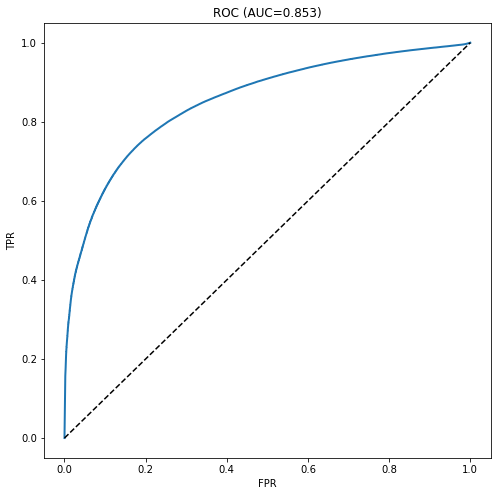

In [506]:
# plot ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_scaled)

fig,ax = plt.subplots(figsize=(8, 8))
ax.plot(fpr, tpr, lw=2)
ax.plot([0, 1], [0, 1], 'k--')
ax.set_title(f'ROC (AUC={auc_score:.3f})')
ax.set_xlabel('FPR')
ax.set_ylabel('TPR');


In [477]:
def get_ordered(y_true_matrix, y_pred_matrix):
    # get order of hits for each user
    sorted_idx = np.argsort(-y_true_matrix, axis=0)
    # order each columns (users) using the sorted indices
    y_true_values = np.hstack([y_true_matrix[sorted_idx[:, i], i].reshape(-1, 1) for i in range(y_true_matrix.shape[1])])
    y_pred_values = np.hstack([y_pred_matrix[sorted_idx[:, i], i].reshape(-1, 1) for i in range(y_pred_matrix.shape[1])])
    return y_true_values, y_pred_values
    

In [478]:
def recall_at_k(y_true_matrix, y_pred_matrix, k):
    # get order of hits for each user
    sorted_idx = np.argsort(-y_true_matrix, axis=0)
    # order each columns (users) using the sorted indices
    y_true_values = np.hstack([y_true_matrix[sorted_idx[:, i], i].reshape(-1, 1) for i in range(y_true_matrix.shape[1])])
    y_pred_values = np.hstack([y_pred_matrix[sorted_idx[:, i], i].reshape(-1, 1) for i in range(y_pred_matrix.shape[1])])
    # get the k top recommendations for each users
    return recall_score(y_true_values[:k, :].ravel(), y_pred_values[:k, :].ravel())

def map_at_k(y_true_matrix, y_pred_matrix, k):
    # get order of hits for each user
    sorted_idx = np.argsort(-y_true_matrix, axis=0)
    # order each columns (users) using the sorted indices
    y_true_values = np.hstack([y_true_matrix[sorted_idx[:, i], i].reshape(-1, 1) for i in range(y_true_matrix.shape[1])])
    y_pred_values = np.hstack([y_pred_matrix[sorted_idx[:, i], i].reshape(-1, 1) for i in range(y_pred_matrix.shape[1])])
    # get the k top recommendations for each users
#     return average_precision_score(y_true_values[:k, :].ravel(), y_pred_values[:k, :].ravel())
    return np.mean(np.array([precision_score(y_true_values[:k, i], y_pred_values[:k, i]) for i in range(y_true_values.shape[1])])>0)

print('-- RECALL')
for k in [3, 5, 10]:
    print(f'recall@{k}:', recall_at_k(users_true_labels.toarray(), users_predictions_binarized, k))

print('-- Mean Average PRECISION')
for k in [3, 5, 10]:
    print(f'map@{k}:', map_at_k(users_true_labels.toarray(), users_predictions_binarized, k))


-- RECALL
recall@3: 0.29237901846474085
recall@5: 0.2994791542570681
recall@10: 0.2948020477267986
-- Mean Average PRECISION


/miniconda3/envs/data-science/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


map@3: 0.650843904888753
map@5: 0.8361536278084675
map@10: 0.8812856175899038


In [470]:
def apk(actual, predicted, k=10):
    """
    Computes the average precision at k.
    This function computes the average prescision at k between two lists of
    items.
    Parameters
    ----------
    actual : list
             A list of elements that are to be predicted (order doesn't matter)
    predicted : list
                A list of predicted elements (order does matter)
    k : int, optional
        The maximum number of predicted elements
    Returns
    -------
    score : double
            The average precision at k over the input lists
    """
    if len(predicted)>k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0

    for i,p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i+1.0)

    if not actual:
        return 0.0

    return score / min(len(actual), k)

def mapk(actual, predicted, k=10):
    """
    Computes the mean average precision at k.
    This function computes the mean average prescision at k between two lists
    of lists of items.
    Parameters
    ----------
    actual : list
             A list of lists of elements that are to be predicted 
             (order doesn't matter in the lists)
    predicted : list
                A list of lists of predicted elements
                (order matters in the lists)
    k : int, optional
        The maximum number of predicted elements
    Returns
    -------
    score : double
            The mean average precision at k over the input lists
    """
    return np.mean([apk(a,p,k) for a,p in zip(actual, predicted)])

# print('-- Mean Average PRECISION')
# for k in [3, 5, 10]:
#     print(f'map@{k}:', map_at_k(users_true_labels.toarray(), users_predictions_binarized, k))

y_true_ordered, y_pred_ordered = get_ordered(users_true_labels.toarray(), users_predictions_binarized)
y_true_mapped = list(map(lambda x: [f'{i}_{int(n)}' for i,n in enumerate(x) if n==1], y_true_ordered[:10].transpose().tolist()))
y_pred_mapped = list(map(lambda x: [f'{i}_{int(n)}' for i,n in enumerate(x)], y_pred_ordered[:10].transpose().tolist()))

mapk(y_true_mapped, y_pred_mapped, 10)
# ap()

0.18629109375966763

# Implicit own evaluation

In [479]:
from implicit_local.evaluation import precision_at_k, mean_average_precision_at_k, train_test_split as tt_split, ndcg_at_k 

full_pivot = results_races_count_binarized.pivot(index='race', columns='athlete', values='count').fillna(0)
train_data, test_data = tt_split(sparse.csr_matrix(full_pivot.values), train_percentage=0.5)

print('Fitting model')
model2 = AlternatingLeastSquares(factors=19, regularization=0.01, iterations=50)
model2.fit(train2, show_progress=False)

k_s = [3, 5, 10]
print('-- Precision')
m = [precision_at_k(model2, train_data.T.tocsr(), test_data.T.tocsr(), K=k, num_threads=4, show_progress=False) for k in k_s]
for i in range(len(k_s)):
    print(f'p@{k_s[i]}:', m[i])


print('-- MAP')
m = [mean_average_precision_at_k(model2, train_data.T.tocsr(), test_data.T.tocsr(), K=k, num_threads=4, show_progress=False) for k in k_s]
for i in range(len(k_s)):
    print(f'map@{k_s[i]}:', m[i])

print('-- NDCG')
m = [ndcg_at_k(model2, train_data.T.tocsr(), test_data.T.tocsr(), K=k, num_threads=4, show_progress=False) for k in k_s]
for i in range(len(k_s)):
    print(f'ndcg@{k_s[i]}:', m[i])

Fitting model
-- Precision
p@3: 0.46899816737935246
p@5: 0.5113550897616167
p@10: 0.6407632074072339
-- MAP
map@3: 0.4076188175128161
map@5: 0.40960792234202426
map@10: 0.4434564736774472
-- NDCG
ndcg@3: 0.47831702975939383
ndcg@5: 0.5010562153294669
ndcg@10: 0.5597730500512695


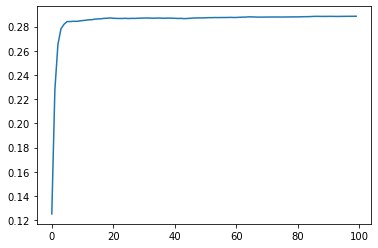

In [420]:
recommender = AlternatingLeastSquares(factors=19, regularization=0.01, iterations=1)

n_iter = 100 
ndcg_results = []
for i in range(n_iter):
    recommender.fit(train_data, show_progress=False) # iterate one time
    
    ndcg = ndcg_at_k(recommender, train_data.T.tocsr(), test_data.T.tocsr(), K=10, num_threads=4, show_progress=False)
    ndcg_results.append(ndcg)

# once finished
plt.plot(ndcg_results)